In [1]:
# Import that good good
import sys
import os
sys.path.append('/Users/kolbt/Desktop/ipython/diam_files')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from IPython.display import display
from collections import OrderedDict
pd.options.display.max_rows = 2
import matplotlib.colors as mc
import colorsys

In [19]:
# Define what functions you'll need here
def getFromTxt(fname, first, last):
    "Takes a string, text before and after desired text, outs text between"
    start = fname.index( first ) + len( first )
    end = fname.index( last, start )
    myTxt = fname[start:end]
    return float(myTxt)
# Above function kindly provided by user "cji" on stackoverflow
# https://stackoverflow.com/questions/3368969/find-string-between-two-substrings

# Make sure data is sorted appropriately
def sortArray(array, sort_var):
    "Takes an array and the column name to sort, sorts array "
    for i in range(0, len(array)):
        for k in range(0, len(array[i])):
            for j in range(0, len(array[i])):
                # Out of order, swap them
                if array[i].loc[j, sort_var] < array[i].loc[k, sort_var] and k < j:
                    print("Sorting... ")
                    tmp = array[i].iloc[j].copy()
                    array[i].iloc[j] = array[i].iloc[k]
                    array[i].iloc[k] = tmp
                    
def plotter(start, stop, ylab):
    "Plotting function so that I don't have to show this a zillion times"
    ind = 0
    for j in range(start, stop):
        for i in range(0, len(SS[headers[j]])):
            # Mixture
            if params['xA'][i] % 100 != 0:
                plt.scatter(params['peA'][i], SS[headers[j]][i], c=col[ind], label=headers[j])
            # Monodisperse, always same color
            else:
                # If it's zero ignore it
                if SS[headers[j]][i] != 0:
                    plt.scatter(params['peA'][i], SS[headers[j]][i], c=col[-1], label='Mono')
        ind += 1
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel('Activity (Pe)')
    plt.ylabel(ylab)
    plt.show()
    
def diamToForce(r):
    "Take diameter, output LJ-force"
    eps = 1.0
    sigma = 1.0
    F_LJ = 24.0 * eps * ((2 * (sigma**12) * (r**-13)) - ((sigma**6) * (r**-7)))
    return F_LJ

def forceToEps(force):
    "Take LJ-force and output epsilon to give diameter of 1"
    epsilon = force / 24.0
    return epsilon

# https://mycurvefit.com/
def linear(a, x, b):
    return (a*x)+b

def powerLaw(a, x, b):
    return a*(x**b)

def exponential(a, b, c, x):
    "Exponential: a - (b/c) * (1 - (e**-cx))"
    return a - ((b/c)*(1-(math.exp(-c*x))))

def plateau(a, x, b):
    "Plateau: a * x / (b + x)"
    return (a * x) / (b + x)

def logarithmic(a, x, b):
    "Logarithmic: a * ln(x) + b"
    if x != 0:
        return (a * math.log(x)) + b
    else:
        return 0
    
# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def colorShade(color, amount=0.5):
    "Gives multiple shades of a base color"
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [3]:
# Get the data files
os.chdir('/Users/kolbt/Desktop/ipython')
txtFiles = os.listdir('eps1')
all_sims = []
print(txtFiles)

['diam_pa0_pb0_xa100.txt', 'diam_pa100_pb0_xa100.txt', 'diam_pa150_pb0_xa100.txt', 'diam_pa200_pb0_xa100.txt', 'diam_pa250_pb0_xa100.txt', 'diam_pa300_pb0_xa100.txt', 'diam_pa350_pb0_xa100.txt', 'diam_pa400_pb0_xa100.txt', 'diam_pa450_pb0_xa100.txt', 'diam_pa500_pb0_xa100.txt', 'diam_pa50_pb0_xa100.txt']


In [4]:
# Using the absolute path means I can go to whatever directory I want
os.chdir('/Users/kolbt/Desktop/ipython/eps1')
for i in range(0, len(txtFiles)):
    df = pd.read_csv(txtFiles[i], sep='\s+', header=0)
    all_sims.append(df)

In [5]:
# Make sure all data is in correct timestep order
sortArray(all_sims, 'Timestep')
display(all_sims[0])

,Timestep,Gas_A,Gas_B,Gas_tot,Dense_A,Dense_B,Dense_tot,Lg_clust,MCS,sigALL,sigAA,sigAB,sigBB,phiEff,lg_clustA,tot_clustA,LC_density,DP_density,GP_density
0,0.0,200000,0,200000,0,0,0,20,0,1.0127,1.0127,0.0,0.0,0.61,16.1,0.0,1.24,0.0,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,199800000.0,200000,0,200000,0,0,0,12,0,1.0020,1.0020,0.0,0.0,0.60,9.5,0.0,1.27,0.0,0.76


In [6]:
# Make an additional frame that gives total number of particles, and simulation parameters
paramList = []
for i in range(0, len(txtFiles)):
    partAll = all_sims[i]['Gas_tot'][0]
    partA = all_sims[i]['Gas_A'][0]
    partB = all_sims[i]['Gas_B'][0]
    pa = getFromTxt(txtFiles[i], "pa", "_pb")
    pb = getFromTxt(txtFiles[i], "pb", "_xa")
    xa = getFromTxt(txtFiles[i], "xa", ".txt")
    try:
        prat = float(pa)/float(pb)
    except:
        prat = 0.0
    paramList.append((partAll, partA, partB, pa, pb, xa, prat))

params = pd.DataFrame(paramList, columns=['partAll', 'partA', 'partB', 'peA', 'peB', 'xA', 'peR'])
display(params)

,partAll,partA,partB,peA,peB,xA,peR
0,200000,200000,0,0.0,0.0,100.0,0.0
...,...,...,...,...,...,...,...
10,200000,200000,0,50.0,0.0,100.0,0.0


In [7]:
# Make list of steady state column headers
headers = list(all_sims[0])
headers.remove('Timestep')
SS = pd.DataFrame(columns=headers)
for i in range(0, len(txtFiles)):
    SS.loc[i] = [0] * len(headers)

# Make dataframe of steady-state data
for i in range(0, len(txtFiles)):
    # Loop through each column (aside from tstep column)
    for j in range(1, len(headers) + 1):
        # Compute mean of last 100 entries in jth column of ith file
        avg = np.mean(all_sims[i].iloc[-100:-1,j])
        SS[headers[j-1]][i] = avg
        
# Normalize by number of particles
# SS['Gas_A'][:] /= params['partA'][:]
# SS['Gas_B'][:] /= params['partB'][:]
# SS['Gas_tot'][:] /= params['partAll'][:]
# SS['Dense_A'][:] /= params['partA'][:]
# SS['Dense_B'][:] /= params['partB'][:]
# SS['Dense_tot'][:] /= params['partAll'][:]
# SS['Lg_clust'][:] /= params['partAll'][:]
# SS['MCS'][:] /= params['partAll'][:]
display(SS)

,Gas_A,Gas_B,Gas_tot,Dense_A,Dense_B,Dense_tot,Lg_clust,MCS,sigALL,sigAA,sigAB,sigBB,phiEff,lg_clustA,tot_clustA,LC_density,DP_density,GP_density
0,200000,0,200000,0,0,0,13.3434,0,1.00646,1.00646,0,0,0.603535,10.6121,0,1.25697,0,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,116713,0,116713,83287.3,0,83287.3,14813,3997.57,0.973223,0.973223,0,0,0.584141,11010.4,61962.9,1.34444,1.34444,0.583636


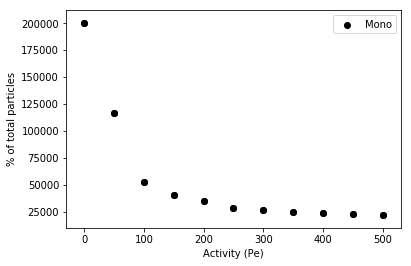

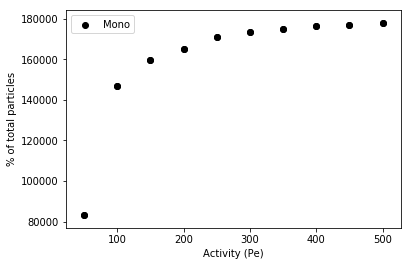

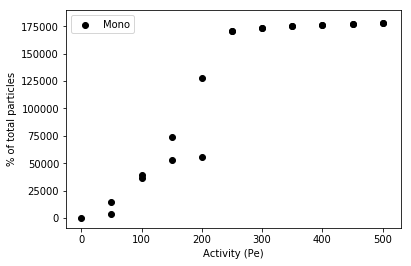

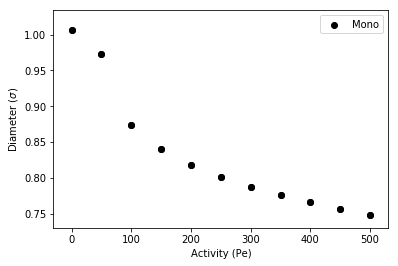

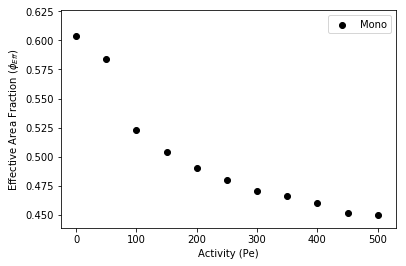

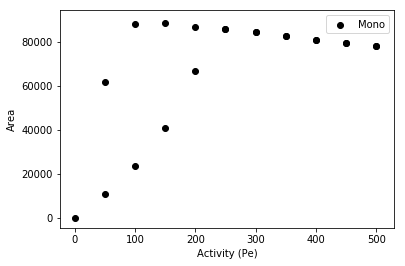

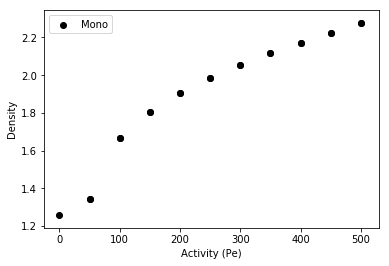

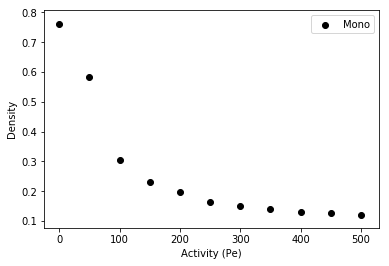

In [8]:
# Plot the data
# col = ['k', 'r', 'g', 'b']
col = ['#e6194b', '#3cb44b', '#0082c8', '#f58231', '#ffe119','#911eb4', '#46f0f0',
       '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff', '#aa6e28', '#fffac8',
       '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000080', '#808080', '#ffffff',
       '#000000']
plotter(0, 3, '% of total particles')
plotter(3, 6, '% of total particles')
plotter(6, 8, '% of total particles')
plotter(8, 12, r'Diameter $(\sigma)$')
plotter(12, 13, r'Effective Area Fraction $(\phi_{Eff})$')
plotter(13, 15, 'Area')
plotter(15, 17, 'Density')
plotter(17, 18, 'Density')

# # This is the way I was plotting it
# for j in range(0, 3):
#     plt.scatter(params['peA'], SS[headers[j]], label=headers[j])
#     plt.legend()
# plt.show()

In [14]:
# Take in the steady-state diameter data... output the LJ force w/ HS epsilon
diam_to_force = []
eps_one = []
for i in range(0, len(SS['sigALL'])):
    diam_to_force.append(diamToForce(SS['sigALL'][i]))
    eps_one.append(forceToEps(diam_to_force[i]))

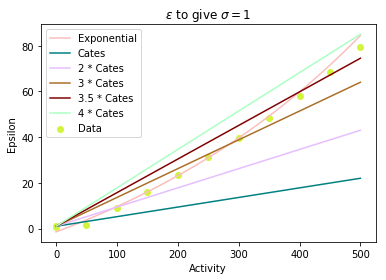

84.99983200000001


In [33]:
# Let's fix the data being plotted (just monodisperse)
mono = [0]
corDat = [1]
for i in range(0, len(params['peA'])):
    if params['xA'][i] % 100 == 0:
        mono.append(params['peA'][i])
        corDat.append(eps_one[i])

expo = []
lin1 = []
lin2 = []
lin3 = []
lin4 = []
lin5 = []
refRange = np.arange(0, 500, 0.001)
for i in range(0, len(refRange)):
    expo.append(exponential(-1.47, -0.10, -0.002, refRange[i]))
    lin1.append(linear(0.042, refRange[i], 1))
    lin2.append(linear(0.084, refRange[i], 1))
    lin3.append(linear(0.126, refRange[i], 1))
    lin4.append(linear(0.147, refRange[i], 1))
    lin5.append(linear(0.168, refRange[i], 1))

plt.scatter(mono, corDat, c=col[8], label='Data')
plt.plot(refRange, expo, c=col[9], label='Exponential')
plt.plot(refRange, lin1, c=col[10], label='Cates')
plt.plot(refRange, lin2, c=col[11], label='2 * Cates')
plt.plot(refRange, lin3, c=col[12], label='3 * Cates')
plt.plot(refRange, lin4, c=col[14], label='3.5 * Cates')
plt.plot(refRange, lin5, c=col[15], label='4 * Cates')
plt.xlabel('Activity')
plt.ylabel('Epsilon')
plt.legend()
plt.title(r'$\epsilon$ to give $\sigma=1$')
plt.show()

print(Activity: {}, Epsilon: {}).format(lin5[-1])

In [16]:
print('Monodisperse Data:')
for i in range(0, len(eps_one)):
    # monodisperse
    if params['xA'][i] % 100 == 0:
        print('Activity: {}, Epsilon: {}').format(params['peA'][i], eps_one[i])
# print('Monodisperse Data:')
# for i in range(0, len(eps_one)):
#     # monodisperse
#     if params['xA'][i] % 100 == 0:
#         print('{} \t {}').format(params['peA'][i], eps_one[i])

Monodisperse Data:
Activity: 0.0, Epsilon: 0.883442177859
Activity: 100.0, Epsilon: 9.0382230056
Activity: 150.0, Epsilon: 15.7785372804
Activity: 200.0, Epsilon: 23.3741313591
Activity: 250.0, Epsilon: 31.1422145771
Activity: 300.0, Epsilon: 39.4415982026
Activity: 350.0, Epsilon: 48.5240852561
Activity: 400.0, Epsilon: 57.8448569696
Activity: 450.0, Epsilon: 68.3155609045
Activity: 500.0, Epsilon: 79.4759546829
Activity: 50.0, Epsilon: 1.63697577855
